In [70]:
import pandas as pd
import zipfile, os
import numpy as np
import csv
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

In [71]:
# Specify the path to your CSV file
!wget https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv

df_beras = pd.read_csv('Beras.csv')
df_beras

--2024-06-16 12:06:44--  https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42658 (42K) [text/plain]
Saving to: ‘Beras.csv.3’

Beras.csv.3         100%[===================>]  41.66K  --.-KB/s    in 0.01s   

2024-06-16 12:06:44 (3.75 MB/s) - ‘Beras.csv.3’ saved [42658/42658]



,Tanggal,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Harga Beras Penggilingan,Produksi Beras,Harga Beras,UMP,BBM Solar,Tingkat Konsumsi
0,2021-03-15,10,4000,4150,5050,9465,14419,11200,4960,9600,17161
1,2021-03-16,10,3850,4100,4740,9360,14419,11200,4960,9600,17161
2,2021-03-17,10,4160,4230,4950,9400,14419,11200,4960,9600,17161
3,2021-03-18,10,4120,4190,4730,9340,14419,11200,4960,9600,17161
4,2021-03-19,10,4190,4290,4990,9410,14419,11200,4960,9600,17161
...,...,...,...,...,...,...,...,...,...,...,...
673,2023-12-21,30,6770,6850,7980,13100,14391,14000,5444,6800,17598
674,2023-12-22,30,6600,6760,8050,13095,14391,14000,5444,6800,17598
675,2023-12-27,30,6620,6760,8030,13120,14391,14000,5444,6800,17598
676,2023-12-28,30,6650,6760,8020,13120,14391,14000,5444,6800,17598


In [72]:
df_beras.drop(['Tanggal'], axis = 1, inplace = True)

In [73]:
df_beras_trend = pd.DataFrame()
df_beras_seasonal = pd.DataFrame()
df_beras_resid = pd.DataFrame()

for series_name, series in df_beras.items():
  stl = STL(df_beras[series_name], period=12, robust=True)
  result = stl.fit()
  df_beras_trend[series_name] = result.trend
  df_beras_seasonal[series_name] = result.seasonal
  df_beras_resid[series_name] = result.resid

In [74]:
# def data_to_X_y(df):
#   X = df.drop('Harga Beras', axis=1)
#   y = df['Harga Beras']

#   return X, y

def data_to_X_y(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][6]
    y.append(label)
  return np.array(X), np.array(y)

X_trend, y_trend = data_to_X_y(df_beras_trend)
X_seasonal, y_seasonal = data_to_X_y(df_beras_seasonal)
X_resid, y_resid = data_to_X_y(df_beras_resid)
X_trend.shape

(672, 6, 10)

In [75]:
def splitting_data(df, X, y):
  cutoff_index = int(len(df) * 0.8)

  # Split the dataset into training and testing sets using the calculated index
  X_train = X[:cutoff_index]
  X_test = X[cutoff_index:]
  y_train = y[:cutoff_index]
  y_test = y[cutoff_index:]

  return X_train, X_test, y_train, y_test

X_train_trend, X_test_trend, y_train_trend, y_test_trend = splitting_data(df_beras_trend, X_trend, y_trend)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = splitting_data(df_beras_seasonal, X_seasonal, y_seasonal)
X_train_resid, X_test_resid, y_train_resid, y_test_resid = splitting_data(df_beras_resid, X_resid, y_resid)

X_train_trend.shape

(542, 6, 10)

In [76]:
y_test_trend

array([12421.58810954, 12421.38690935, 12421.17616695, 12420.93984769,
       12420.68770403, 12420.4542889 , 12420.24778023, 12420.04576115,
       12419.84786501, 12419.71470897, 12419.70712492, 12419.90965437,
       12420.30052265, 12420.84128974, 12421.73001443, 12423.2694792 ,
       12425.76012651, 12429.36506994, 12433.64228586, 12437.94657357,
       12442.4612124 , 12447.48419259, 12453.15619406, 12463.40317629,
       12486.74755836, 12505.98814779, 12518.32390212, 12528.77482027,
       12539.49362202, 12553.56972422, 12569.00501254, 12583.85379816,
       12597.20163968, 12609.077213  , 12637.14789466, 12673.30623345,
       12721.55654102, 12778.13650501, 12831.74789502, 12885.33250092,
       12937.81792941, 12989.30427619, 13040.00309546, 13089.56383983,
       13136.20429017, 13174.80035571, 13225.05794684, 13287.77678273,
       13350.49967802, 13413.22934306, 13475.97199137, 13538.73517792,
       13601.5283507 , 13572.64954856, 13585.05410871, 13617.3271102 ,
      

In [77]:
from sklearn.preprocessing import MinMaxScaler
trend_scaler = MinMaxScaler(feature_range=(-1,1))
seasonal_scaler = MinMaxScaler(feature_range=(-1,1))
resid_scaler = MinMaxScaler(feature_range=(-1,1))
asli_scaler = MinMaxScaler(feature_range=(-1,1))
# X_trend_scaler = MinMaxScaler(feature_range=(-1,1))
# y_trend_scaler = MinMaxScaler(feature_range=(-1,1))
# X_seasonal_scaler = MinMaxScaler(feature_range=(-1,1))
# y_seasonal_scaler = MinMaxScaler(feature_range=(-1,1))
# X_resid_scaler = MinMaxScaler(feature_range=(-1,1))
# y_resid_scaler = MinMaxScaler(feature_range=(-1,1))

def scaling_data(scaler, X_train, X_test, y_train, y_test):
  X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
  X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))

  y_train = scaler.fit_transform(y_train.reshape(-1,1))
  y_test = scaler.transform(y_test.reshape(-1,1))

  return X_train, X_test, y_train, y_test

# def X_scaling_data(scaler, X_train, X_test):
#   X_train = scaler.fit_transform(np.array(X_train).reshape(X_train.shape[0], -1))
#   X_test = scaler.transform(np.array(X_test).reshape(X_test.shape[0], -1))
#   return X_train, X_test

# def y_scaling_data(scaler, y_train, y_test):
#   y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
#   y_test = scaler.transform(np.array(y_test).reshape(-1,1))
#   return y_train, y_test

X_train_trend, X_test_trend, y_train_trend, y_test_trend = scaling_data(trend_scaler, X_train_trend, X_test_trend, y_train_trend, y_test_trend)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = scaling_data(seasonal_scaler, X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal)
X_train_resid, X_test_resid, y_train_resid, y_test_resid = scaling_data(resid_scaler, X_train_resid, X_test_resid, y_train_resid, y_test_resid)
# X_train_trend, X_test_trend = X_scaling_data(X_trend_scaler, X_train_trend, X_test_trend)
# y_train_trend, y_test_trend = y_scaling_data(y_trend_scaler, y_train_trend, y_test_trend)
# X_train_seasonal, X_test_seasonal = X_scaling_data(X_seasonal_scaler, X_train_seasonal, X_test_seasonal)
# y_train_seasonal, y_test_seasonal = y_scaling_data(y_seasonal_scaler, y_train_seasonal, y_test_seasonal)
# X_train_resid, X_test_resid = X_scaling_data(X_resid_scaler, X_train_resid, X_test_resid)
# y_train_resid, y_test_resid = y_scaling_data(y_resid_scaler, y_train_resid, y_test_resid)

In [78]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [79]:
def modelling_data(X_train, y_train):
  lin_model.fit(X_train, y_train)

  return lin_model

model_trend = modelling_data(X_train_trend, y_train_trend)
model_seasonal = modelling_data(X_train_seasonal, y_train_seasonal)
model_resid = modelling_data(X_train_resid, y_train_resid)

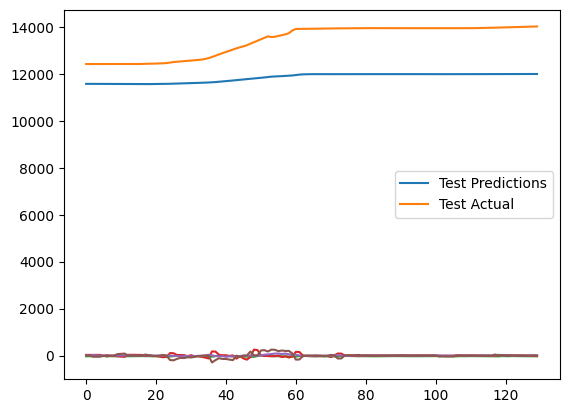

In [80]:
def predicting_data(scaler, lin_model, X_test, y_test):
  lin_pred=lin_model.predict(X_test)
  lin_pred_inv = scaler.inverse_transform(lin_pred.reshape(-1,1))

  plt.plot(lin_pred_inv)
  plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
  plt.legend(['Test Predictions', 'Test Actual'])

  # plt.rcParams["figure.figsize"] = (11,6)
  # # lin_pred_inv = scaler.inverse_transform(lin_pred.reshape(-1,1))
  # plt.plot(lin_pred,label='Linear_Regression_Predictions')
  # plt.plot(y_test,label='Actual Sales')
  # plt.legend(loc="upper left")
  # plt.show()

  return lin_pred_inv

predict_trend = predicting_data(trend_scaler, model_trend, X_test_trend, y_test_trend)
predict_seasonal = predicting_data(seasonal_scaler, model_seasonal, X_test_seasonal, y_test_seasonal)
predict_resid = predicting_data(resid_scaler, model_resid, X_test_resid, y_test_resid)

In [81]:
data_predict_jumlah = predict_trend + predict_seasonal + predict_resid
data_predict_jumlah

array([[11556.14427205],
       [11552.8432946 ],
       [11568.91498311],
       [11552.74090416],
       [11543.90594957],
       [11543.71716704],
       [11543.37673595],
       [11535.98082527],
       [11536.65588838],
       [11535.63733496],
       [11542.45850679],
       [11538.91679801],
       [11539.36382929],
       [11539.59059605],
       [11531.64591899],
       [11536.17765211],
       [11539.69851026],
       [11550.03695618],
       [11546.41570777],
       [11542.2881271 ],
       [11542.3952668 ],
       [11535.84166678],
       [11543.66502017],
       [11533.94792189],
       [11538.76404082],
       [11543.49877221],
       [11553.39359182],
       [11534.68954289],
       [11554.50525723],
       [11554.79927406],
       [11542.16822874],
       [11562.8233374 ],
       [11572.07373235],
       [11571.30821041],
       [11595.05764037],
       [11622.98170272],
       [11602.92117388],
       [11606.29714846],
       [11627.72795807],
       [11638.47535279],


In [82]:
y_test_trend_scaler_inverse = trend_scaler.inverse_transform(y_test_trend.reshape(-1,1))
y_test_seasonal_scaler_inverse = seasonal_scaler.inverse_transform(y_test_seasonal.reshape(-1,1))
y_test_resid_scaler_inverse = resid_scaler.inverse_transform(y_test_resid.reshape(-1,1))
y_test_asli = y_test_trend_scaler_inverse + y_test_seasonal_scaler_inverse + y_test_resid_scaler_inverse
y_test_asli

array([[12450.],
       [12450.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12500.],
       [12500.],
       [12550.],
       [12550.],
       [12550.],
       [12550.],
       [12600.],
       [12750.],
       [12750.],
       [12750.],
       [12800.],
       [12800.],
       [12850.],
       [12950.],
       [13050.],
       [13050.],
       [13050.],
       [13400.],
       [13600.],
       [13650.],
       [13700.],
       [13750.],
       [13750.],
       [13800.],
       [13800.],
       [13800.],
       [13800.],
       [13850.],
       [13850.

# Trend MEtric

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_trend, y_test_trend_scaler_inverse))
mae = mean_absolute_error(predict_trend,y_test_trend_scaler_inverse)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_trend,y_test_trend_scaler_inverse)

# Mean Magnitude of Relative Error
mmre = (abs((predict_trend - y_test_trend_scaler_inverse) / y_test_trend_scaler_inverse)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_trend - y_test_trend_scaler_inverse) / y_test_trend_scaler_inverse))

# Mean Magnitude of Error Relative
mmer = (abs(predict_trend - y_test_trend_scaler_inverse)).mean()

# Mean Square Error
mse = mean_squared_error(predict_trend, y_test_trend_scaler_inverse)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 1651.0955384415647
Mean Absolute Error: 1582.055433569142
R Square: -82.3468
Mean Magnitude of Relative Error: 0.1164
Median Magnitude of Relative Error: 0.1394
Mean Magnitude of Error Relative:  1582.055433569142
Mean Square Error: 2726116.4770616405


# Seasonal Metric

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_seasonal, y_test_seasonal_scaler_inverse))
mae = mean_absolute_error(predict_seasonal,y_test_seasonal_scaler_inverse)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_seasonal,y_test_seasonal_scaler_inverse)

# Mean Magnitude of Relative Error
mmre = (abs((predict_seasonal - y_test_seasonal_scaler_inverse) / y_test_seasonal_scaler_inverse)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_seasonal - y_test_seasonal_scaler_inverse) / y_test_seasonal_scaler_inverse))

# Mean Magnitude of Error Relative
mmer = (abs(predict_seasonal - y_test_seasonal_scaler_inverse)).mean()

# Mean Square Error
mse = mean_squared_error(predict_seasonal, y_test_seasonal_scaler_inverse)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 63.77995018321085
Mean Absolute Error: 40.236614814095766
R Square: -61.3021
Mean Magnitude of Relative Error: 8.0716
Median Magnitude of Relative Error: 1.8871
Mean Magnitude of Error Relative:  40.236614814095766
Mean Square Error: 4067.8820453728576


# Resid Metric

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_resid, y_test_resid_scaler_inverse))
mae = mean_absolute_error(predict_resid,y_test_resid_scaler_inverse)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_resid,y_test_resid_scaler_inverse)

# Mean Magnitude of Relative Error
mmre = (abs((predict_resid - y_test_resid_scaler_inverse) / y_test_resid_scaler_inverse)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_resid - y_test_resid_scaler_inverse) / y_test_resid_scaler_inverse))

# Mean Magnitude of Error Relative
mmer = (abs(predict_resid - y_test_resid_scaler_inverse)).mean()

# Mean Square Error
mse = mean_squared_error(predict_resid, y_test_resid_scaler_inverse)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 74.3619453008579
Mean Absolute Error: 43.12807810339173
R Square: -10.6326
Mean Magnitude of Relative Error: 17.4753
Median Magnitude of Relative Error: 1.0018
Mean Magnitude of Error Relative:  43.12807810339173
Mean Square Error: 5529.698908927781


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(data_predict_jumlah,y_test_asli))
mae = mean_absolute_error(data_predict_jumlah,y_test_asli)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(data_predict_jumlah,y_test_asli)

# Mean Magnitude of Relative Error
mmre = (abs((data_predict_jumlah - y_test_asli) / y_test_asli)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((data_predict_jumlah - y_test_asli) / y_test_asli))

# Mean Magnitude of Error Relative
mmer = (abs(data_predict_jumlah - y_test_asli)).mean()

# Mean Square Error
mse = mean_squared_error(data_predict_jumlah, y_test_asli)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 1676.5768203440093
Mean Absolute Error: 1603.397903902702
R Square: -79.9581
Mean Magnitude of Relative Error: 0.1179
Median Magnitude of Relative Error: 0.1397
Mean Magnitude of Error Relative:  1603.397903902702
Mean Square Error: 2810909.834514829


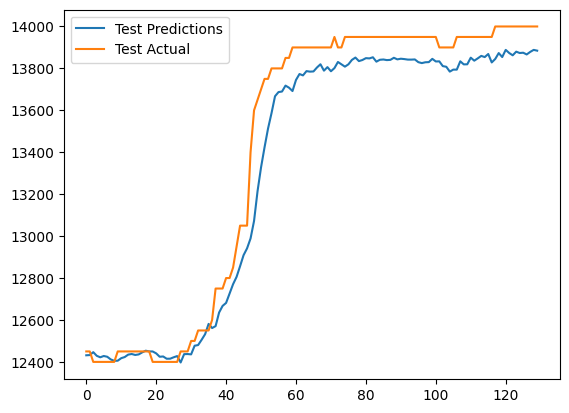

In [87]:
X_asli, y_asli = data_to_X_y(df_beras)
X_train_asli, X_test_asli, y_train_asli, y_test_asli = splitting_data(df_beras, X_asli, y_asli)
X_train_asli, X_test_asli, y_train_asli, y_test_asli = scaling_data(asli_scaler, X_train_asli, X_test_asli, y_train_asli, y_test_asli)
model_asli = modelling_data(X_train_asli, y_train_asli)
predict_asli = predicting_data(asli_scaler, model_asli, X_test_asli, y_test_asli)
y_test_asli = asli_scaler.inverse_transform(y_test_asli.reshape(-1,1))

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_asli,y_test_asli))
mae = mean_absolute_error(predict_asli,y_test_asli)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_asli,y_test_asli)

# Mean Magnitude of Relative Error
mmre = (abs((predict_asli - y_test_asli) / y_test_asli)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_asli - y_test_asli) / y_test_asli))

# Mean Magnitude of Error Relative
mmer = (abs(predict_asli - y_test_asli)).mean()

# Mean Square Error
mse = mean_squared_error(predict_asli, y_test_asli)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 130.95707706935264
Mean Absolute Error: 103.66021917416408
R Square: 0.9566
Mean Magnitude of Relative Error: 0.0076
Median Magnitude of Relative Error: 0.0077
Mean Magnitude of Error Relative:  103.66021917416408
Mean Square Error: 17149.756034548365
